In [2]:
import pandas as pd

df_data = pd.read_excel('C:/Users/09368/workspace/data/excel/Article_economy_202101_202104.xlsx')

print(len(df_data))

title  = df_data['title'].values.tolist()
body   = df_data['body'].values.tolist()
date   = df_data['date'].values.tolist()
source = df_data['source'].values.tolist()

18472


### LDA Topic Modeling
##### 다양한 키워드를 기반으로 내용을 유형화(그룹화)시켜, 단어나 문서의 숨겨진 주제(TOPIC)을 찾아냄

##### 명사 추출 (konlpy)

In [3]:
from konlpy.tag import Kkma
import re
from string import punctuation
import time
import datetime

start = time.time()
kkma  = Kkma()

dataset = []

test_title = title[:1000]

# 구두점 제거
def strip_puncuation(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for title in test_title:
    clean = strip_puncuation(title)
    clean_title.append(clean)
    
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\\s]','', clean_title[i])))

# processing time
sec   = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

0:01:23


##### Corpus Dictionary 언어모델 형성 (gensim)

In [4]:
# 단어의 비중이 너무 큰 의미없는 단어 제거
# 토픽모델링(pyLDAvis) 시각화 이후, 다시 전처리
clean_title2 = []
for i in range(len(clean_title)):
    clean_title2.append(re.sub('새해','',clean_title[i]))
    
clean_title3 = []
for i in range(len(clean_title)):
    clean_title3.append(re.sub('신년','',clean_title2[i]))
    
clean_title4 = []
for i in range(len(clean_title)):
    clean_title4.append(re.sub('올해','',clean_title3[i]))
    
clean_title5 = []
for i in range(len(clean_title)):
    clean_title5.append(re.sub('지난해','',clean_title4[i]))

dataset = []
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\\s]','', clean_title5[i])))

In [6]:
from gensim import corpora, models # LDA 적용을 위한 텍스트의 벡터화
import gensim

high_score_reviews = dataset

high_score_reviews = [[y for y in x if not len(y) == 1]
                      for x in high_score_reviews]

# 데이터를 dictionary형태로 명사 리스트 만들기
dictionary = corpora.Dictionary(high_score_reviews)

# vector로 변환한 bag of words(corpus) 결과물
corpus = [dictionary.doc2bow(text) for text in high_score_reviews]

print(corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(4, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


##### CoherenceModel 을 통한 모델 평가 및 토픽 최적화

In [8]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

"""
CoherenceModel 을 통한 토픽 최적화

토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
주 용도: 해당 모델이 얼마나 실제로 의미 있는 결과를 내는지 확인
"""

coherence_values = []
for i in range(2, 15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    

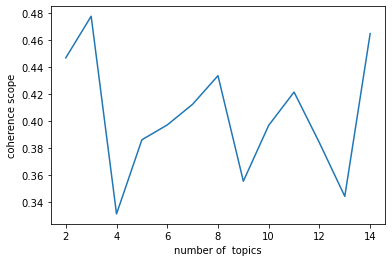

In [7]:
x = range(2, 15)

plt.plot(x, coherence_values)
plt.xlabel("number of  topics")
plt.ylabel("coherence scope")
plt.show()

#####  LDA 시각화

In [9]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=8, alpha=0.1, id2word=dictionary)
ldamodel.print_topics(num_words=20)

[(0,
  '0.040*"수출" + 0.010*"장관" + 0.010*"코로나" + 0.009*"증가" + 0.008*"현장" + 0.007*"연속" + 0.007*"작년" + 0.007*"달러" + 0.007*"성윤모" + 0.007*"개월" + 0.005*"경제" + 0.005*"부동산" + 0.005*"기대" + 0.005*"병원성" + 0.005*"최고" + 0.004*"반등" + 0.004*"돌파" + 0.004*"역대" + 0.003*"지역" + 0.003*"무역"'),
 (1,
  '0.017*"수출" + 0.013*"코로나" + 0.008*"달러" + 0.006*"돌파" + 0.005*"증가" + 0.005*"부산" + 0.004*"감소" + 0.004*"농장" + 0.004*"병원성" + 0.004*"기업" + 0.004*"역대" + 0.004*"경기" + 0.004*"억달러" + 0.004*"반도체" + 0.004*"연간" + 0.003*"중국" + 0.003*"정책" + 0.003*"사용" + 0.003*"개미" + 0.003*"백신"'),
 (2,
  '0.016*"코로나" + 0.007*"태원" + 0.007*"회장" + 0.006*"시장" + 0.006*"기업가" + 0.006*"개미" + 0.005*"정신" + 0.005*"최대" + 0.005*"작년" + 0.004*"연금" + 0.004*"동학" + 0.004*"주택" + 0.004*"강화" + 0.004*"동학개미" + 0.003*"필요" + 0.003*"최고" + 0.003*"사회" + 0.003*"장관" + 0.003*"보험" + 0.003*"생명"'),
 (3,
  '0.021*"수출" + 0.017*"최고" + 0.015*"사상" + 0.011*"태원" + 0.011*"필요" + 0.010*"정신" + 0.010*"기업가" + 0.010*"회장" + 0.008*"마감" + 0.008*"증시" + 0.008*"반도체" + 0.008*"사회" + 0.008*"뉴욕" + 0.

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

pyLDAvis.save_html(vis, 'lda.html')
# export html file

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.111624 -0.098260       1        1  17.026552
0      0.067374  0.083779       2        1  16.718904
6     -0.133856 -0.035978       3        1  12.811491
4      0.050344 -0.004625       4        1  11.726127
2     -0.009745 -0.064403       5        1  11.079035
7     -0.052613 -0.057628       6        1  10.770101
1      0.016112  0.088781       7        1  10.519557
5     -0.049239  0.088334       8        1   9.348233, topic_info=     Term        Freq       Total Category  logprob  loglift
66     수출  102.000000  102.000000  Default  30.0000  30.0000
653    사상   26.000000   26.000000  Default  29.0000  29.0000
747   기업가   20.000000   20.000000  Default  28.0000  28.0000
754    태원   25.000000   25.000000  Default  27.0000  27.0000
753    정신   20.000000   20.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
9      달러    2.802038   30.037500   Topic8  -5.4875  -0.0021
1060   장관    2.801884   31.871145   Topic8  -5.4875  -0.0614
14     한국    2.142476   16.267830   Topic8  -5.7558   0.3428
154    농장    2.122922   13.401493   Topic8  -5.7650   0.5274
871    혁신    2.122810   10.059849   Topic8  -5.7651   0.8142

[560 rows x 6 columns], token_table=      Topic      Freq Term
term                      
468       2  0.148195   가격
468       4  0.148195   가격
468       5  0.148195   가격
468       6  0.296390   가격
468       7  0.296390   가격
...     ...       ...  ...
43        8  0.485068  횡성군
1614      1  0.150297   흑자
1614      2  0.450891   흑자
1614      4  0.150297   흑자
1614      5  0.150297   흑자

[1153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 5, 3, 8, 2, 6])

##### 토픽에 할당된 키워드 추출 (Topic-Keyword)

In [12]:
"""
각 토픽에 할당된 단어와 단어별 토픽 차지 비율 추출
"""

kk = ldamodel.show_topic(7, topn=8000)
type(ldamodel.show_topic)

kk2=pd.DataFrame(kk)
kk2.head(50)

,0,1
0,코로나,0.011408
1,인천,0.007061
2,컨테이너,0.006193
3,백신,0.005324
4,한국,0.005324
5,사회,0.005235
6,스마트,0.004455
7,한진,0.004455
8,터미널,0.004454
9,장관,0.004453


In [54]:
def make_topictable_per_doc(ldamodel, corpus, title):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break

    return topic_table

topictable = make_topictable_per_doc(ldamodel, corpus, title)
topictable = topictable.reset_index()

topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

for headline in test_title:
    topictable['뉴스 headline'] = df_data['title'][:1000]

topictable

,문서번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중,뉴스 headline
0,0,7.0,0.9286,"[(0, 0.010205997), (1, 0.010206684), (2, 0.010...",세진중공업 560억 규모 육상플랜트 모듈 수주
1,1,2.0,0.9286,"[(0, 0.010206683), (1, 0.010207197), (2, 0.928...",한국조선해양 지난해 수주액 100억 달러…목표 91% 달성
2,2,4.0,0.8541,"[(0, 0.02084325), (1, 0.020842383), (2, 0.0208...",“경기 하락세 1분기에는 다소 완화될 듯”
3,3,6.0,0.6100,"[(0, 0.012823375), (1, 0.012825863), (2, 0.012...",울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아
4,4,3.0,0.9286,"[(0, 0.010205177), (1, 0.010205544), (2, 0.010...",공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트
...,...,...,...,...,...
995,995,2.0,0.8541,"[(0, 0.02083611), (1, 0.020836983), (2, 0.8541...",SSG닷컴 새해 맞아 식료품 최대 68% 할인
996,996,2.0,0.9102,"[(0, 0.012824504), (1, 0.012823717), (2, 0.910...",새해 맞이 쇼핑이나 해볼까…백화점 이월 상품전 50% 할인
997,997,4.0,0.8793,"[(0, 0.017244194), (1, 0.017244747), (2, 0.017...",첫 입국 환영 행사 대신…조용한 새해 맞는 항공업계
998,998,0.0,0.9102,"[(0, 0.9102318), (1, 0.012825135), (2, 0.01282...",코로나19 이후 기본소득 복지의 새로운 대안인가
